<a href="https://colab.research.google.com/github/nsrnkha/PCD_2006154/blob/main/PCD_Shape_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shape Image Classification 

# Importing required Libraries

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report


In [ ]:
image_dir=Path('../input/basicshapes/shapes')

# Creating File DataFrame

In [ ]:
file_path=list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))
file_path=pd.Series(file_path,name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([file_path, labels], axis=1)
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_df.shape

(420, 2)

In [ ]:
test_df.shape

(180, 2)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 336 validated image filenames belonging to 3 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 84 validated image filenames belonging to 3 classes.
Found 180 validated image filenames belonging to 3 classes.


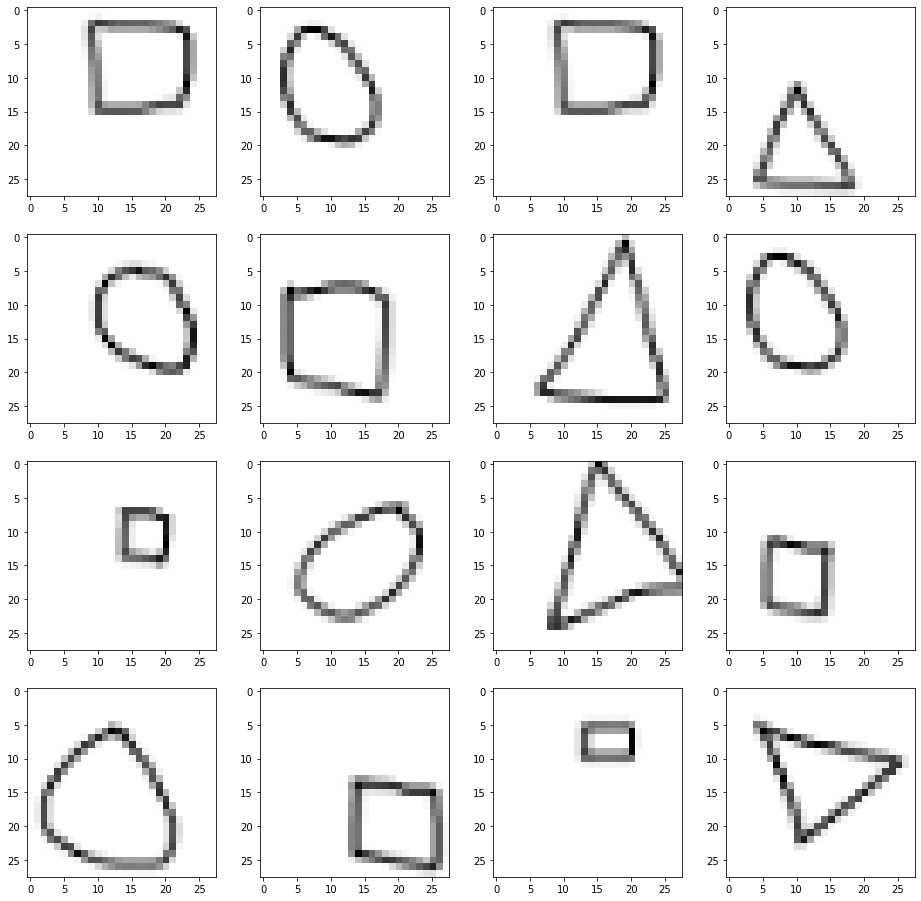

In [ ]:
fig, ax = plt.subplots(4,4,figsize=(16,16))
for i in range(16):
    ind = np.random.randint(32)
    image = train_images[0][0][ind]
    ax[i//4][i%4].imshow(image, cmap='gray')
    

In [ ]:
model = Sequential([
    Conv2D(16,(3,3), input_shape=(28,28,1)),
    LeakyReLU(),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3)),
    LeakyReLU(),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    Flatten(),
    Dense(512),
    Dropout(0.5),
    LeakyReLU(),
    Dense(256),
    LeakyReLU(),
    Dropout(0.5),
    Dense(3, activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 26, 26, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0

In [ ]:

# model = tf.keras.Model(inputs=model, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('./model.h5', save_best_only=True, save_weights_only=True)
    ]
)

Epoch 1/100
11/11 [==============================] - 6s 248ms/step - loss: 1.1129 - accuracy: 0.3460 - val_loss: 1.0883 - val_accuracy: 0.2857
Epoch 2/100
11/11 [==============================] - 0s 27ms/step - loss: 1.0986 - accuracy: 0.3448 - val_loss: 1.0633 - val_accuracy: 0.4643
Epoch 3/100
11/11 [==============================] - 0s 28ms/step - loss: 1.0906 - accuracy: 0.3583 - val_loss: 1.0365 - val_accuracy: 0.5476
Epoch 4/100
11/11 [==============================] - 0s 28ms/step - loss: 1.0416 - accuracy: 0.4661 - val_loss: 0.9356 - val_accuracy: 0.7500
Epoch 5/100
11/11 [==============================] - 0s 28ms/step - loss: 0.9218 - accuracy: 0.6579 - val_loss: 0.7763 - val_accuracy: 0.7143
Epoch 6/100
11/11 [==============================] - 0s 28ms/step - loss: 0.7685 - accuracy: 0.6779 - val_loss: 0.7890 - val_accuracy: 0.6310
Epoch 7/100
11/11 [==============================] - 0s 27ms/step - loss: 0.8319 - accuracy: 0.6109 - val_loss: 0.6024 - val_accuracy: 0.7976
Epoch

In [ ]:
model.load_weights('./model.h5')

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Loss: {:.4f}".format(results[0]))
print("Accuracy: {:.2f}%".format(results[1] * 100))

    Loss: 0.2143
Accuracy: 96.11%
